In [1]:
student_Name='Bobb Shields'
student_ID='wde677'
dataset_URL='https://www.kaggle.com/datasets/sheacon/tn-mvr-2018-2022'

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split


Noting changes made 4/4 due to mistakes in data prep.  "HINO" is a commercial truck manufacturer, so removed from imports category, pushing it into other.  And the sports mask was showing the imports group - corrected that typo.  

4/29 Update - Dropped commercial trucks and winnebagos that dont' fit the cars + trucks schema.  These were supposed to have been dropped in filtering down on type variable.  Changes made in Data Prep notebook, iterated the filename to v3. 

Filters have been applied to reduce this to automobiles only, less than 500k miles, less than 100 years old, less than $10mil, 

Things need to be checked.  MERC and MERZ fixed in download but look for further duplicates.  Model A's shown in these transactions so maybe an age limit is appropriate.  Not sure that a Nissan Altima will appreciate the same way as a Model A lol 

Check for duplicate records per VIN and look at historical trends <- Stretch goal, struggling 4/17

Treat new car price averages as maximum, unless luxury/discontinued brings a postitive curve due to antique-ness <-Still brewing


In [2]:
import time
startTime = time.time()
mostRecentTime = startTime

nowish = (time.time() - startTime)
print('Start time: ' + str(nowish))
print("(in seconds)")

Start time: 0.0005068778991699219
(in seconds)


In [3]:
#have filtered down the project dataset 
tn_auto_reg_f = pd.read_csv('tn_auto_reg_filtered_CT3.csv',low_memory=False)
tn_auto_reg_f.describe().round()

,price,odometer_type,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK,new_used_N,new_used_U
count,1236247.0,1236247.0,1236247.0,1236247.0,1236247.0,1236247.0,1236247.0,1236247.0,1236247.0,1236247.0,1236247.0,1236247.0,1236247.0,1236247.0,1236247.0
mean,22562.0,0.0,69342.0,2015.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
std,22200.0,1.0,66396.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,300.0,0.0,1.0,1915.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,7500.0,0.0,8134.0,2012.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
50%,18500.0,0.0,54403.0,2016.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
75%,32341.0,0.0,112935.0,2019.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
max,9534253.0,9.0,750000.0,2023.0,105.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Data loaded: ' + str(round(nowish,0)) )
print("Last section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Data loaded: 8.0
Last section took: 8.0
(in seconds)


In [5]:
tn_auto_reg_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236247 entries, 0 to 1236246
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   vin                    1236247 non-null  object 
 1   price                  1236247 non-null  float64
 2   odometer_type          1236247 non-null  int64  
 3   mileage                1236247 non-null  int64  
 4   county                 1236247 non-null  object 
 5   zip                    1236247 non-null  object 
 6   model_year             1236247 non-null  int64  
 7   make                   1236247 non-null  object 
 8   model                  1236247 non-null  object 
 9   vehicle_type           1236247 non-null  object 
 10  new_used               1236247 non-null  object 
 11  title_issue_date       1236247 non-null  object 
 12  purchase_date          1236247 non-null  object 
 13  age                    1236247 non-null  int64  
 14  make_cat_popular  

In [6]:
# Define mask variables
mask_popular = tn_auto_reg_f['make_cat_popular'] == 1
mask_sports = tn_auto_reg_f['make_cat_sports'] == 1
mask_imports = tn_auto_reg_f['make_cat_imports'] == 1
mask_luxury = tn_auto_reg_f['make_cat_luxury'] == 1
mask_discontinued = tn_auto_reg_f['make_cat_discontinued'] == 1
mask_other = tn_auto_reg_f['make_cat_other'] == 1
mask_auto = tn_auto_reg_f['type_AUTO'] == 1
mask_truck = tn_auto_reg_f['type_TRUCK'] == 1
mask_new = tn_auto_reg_f['new_used_N'] == 1
mask_used = tn_auto_reg_f['new_used_U'] == 1

Text(0, 0.5, 'Number of Registration Transactions')

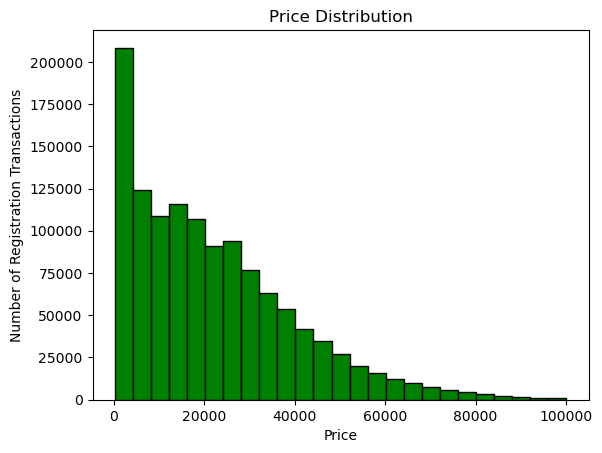

In [7]:
#plot the distribution of the price values

temp = tn_auto_reg_f.loc[tn_auto_reg_f["price"]<100000]
plt.hist(temp['price'], color='green', ec='black', bins=25) #, range=[0,60])
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Number of Registration Transactions")

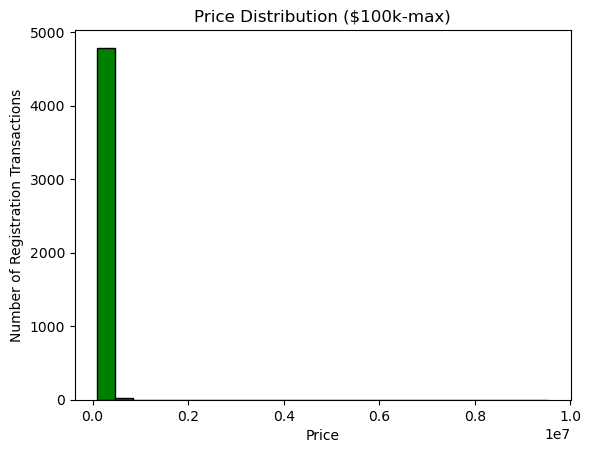

Note the drastically different range when compared to the 0-100K distribution above.  Only 3.5k max num transactions.


In [8]:
#plot the distribution of the price values
temp = tn_auto_reg_f.loc[tn_auto_reg_f["price"]>=100000]
plt.hist(temp['price'], color='green', ec='black', bins=25) #, range=[0,60])
plt.title("Price Distribution ($100k-max)")
plt.xlabel("Price")
plt.ylabel("Number of Registration Transactions")
plt.show()
print("Note the drastically different range when compared to the 0-100K distribution above.  Only 3.5k max num transactions.")

            price  mileage   age  new_used_U  new_used_N  type_AUTO  \
price        1.00    -0.52 -0.52       -0.43        0.43      -0.19   
mileage     -0.52     1.00  0.69        0.50       -0.50      -0.03   
age         -0.52     0.69  1.00        0.49       -0.49       0.01   
new_used_U  -0.43     0.50  0.49        1.00       -1.00       0.05   
new_used_N   0.43    -0.50 -0.49       -1.00        1.00      -0.05   
type_AUTO   -0.19    -0.03  0.01        0.05       -0.05       1.00   
type_TRUCK   0.19     0.03 -0.01       -0.05        0.05      -1.00   

            type_TRUCK  
price             0.19  
mileage           0.03  
age              -0.01  
new_used_U       -0.05  
new_used_N        0.05  
type_AUTO        -1.00  
type_TRUCK        1.00  


<AxesSubplot: title={'center': 'Population - New/Used Cars/Trucks'}>

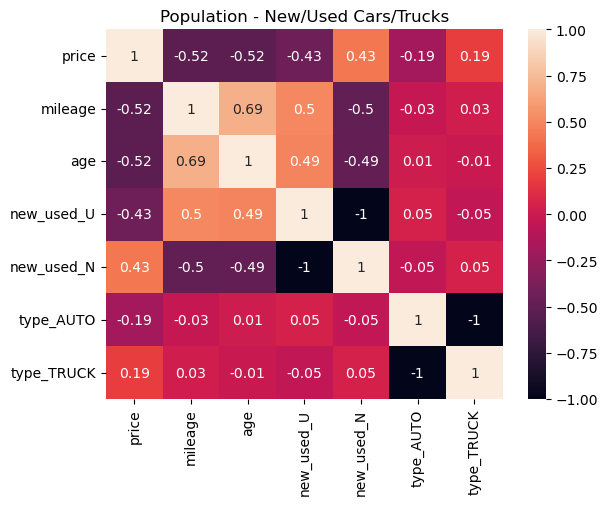

In [9]:
#overall corr analysis
tn_auto_reg_f_hm = tn_auto_reg_f[["price","mileage","age",'new_used_U','new_used_N',"type_AUTO","type_TRUCK"]].corr().round(2)
print(tn_auto_reg_f_hm)
plt.title("Population - New/Used Cars/Trucks")
sns.heatmap(tn_auto_reg_f_hm, annot=True)

                       price  make_cat_popular  make_cat_imports  \
price                   1.00             -0.04             -0.04   
make_cat_popular       -0.04              1.00             -0.57   
make_cat_imports       -0.04             -0.57              1.00   
make_cat_sports         0.10             -0.45             -0.05   
make_cat_luxury         0.08             -0.36             -0.04   
make_cat_discontinued  -0.06             -0.38             -0.04   
make_cat_other          0.00             -0.25             -0.03   

                       make_cat_sports  make_cat_luxury  \
price                             0.10             0.08   
make_cat_popular                 -0.45            -0.36   
make_cat_imports                 -0.05            -0.04   
make_cat_sports                   1.00            -0.03   
make_cat_luxury                  -0.03             1.00   
make_cat_discontinued            -0.03            -0.03   
make_cat_other                   -0.02    

<AxesSubplot: title={'center': 'Population - Make Categories'}>

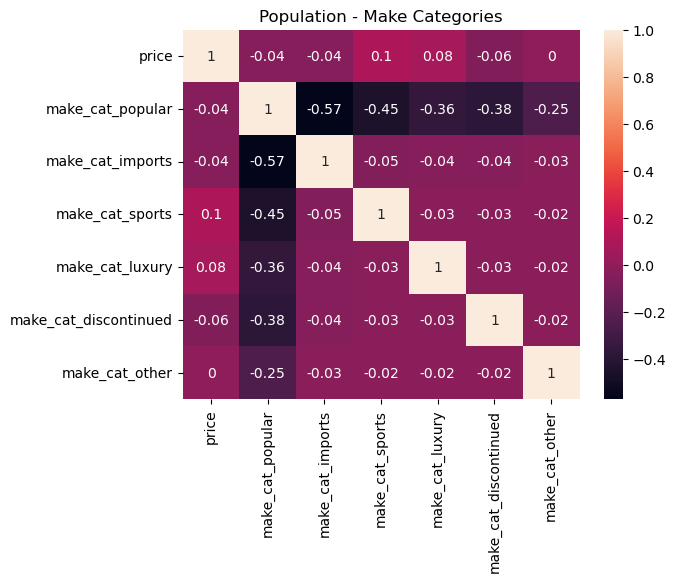

In [10]:
#overall corr analysis
tn_auto_reg_f_hm = tn_auto_reg_f[["price",'make_cat_popular','make_cat_imports','make_cat_sports',
                                  "make_cat_luxury","make_cat_discontinued","make_cat_other"]].corr().round(2)
print(tn_auto_reg_f_hm)
plt.title("Population - Make Categories")
sns.heatmap(tn_auto_reg_f_hm, annot=True)


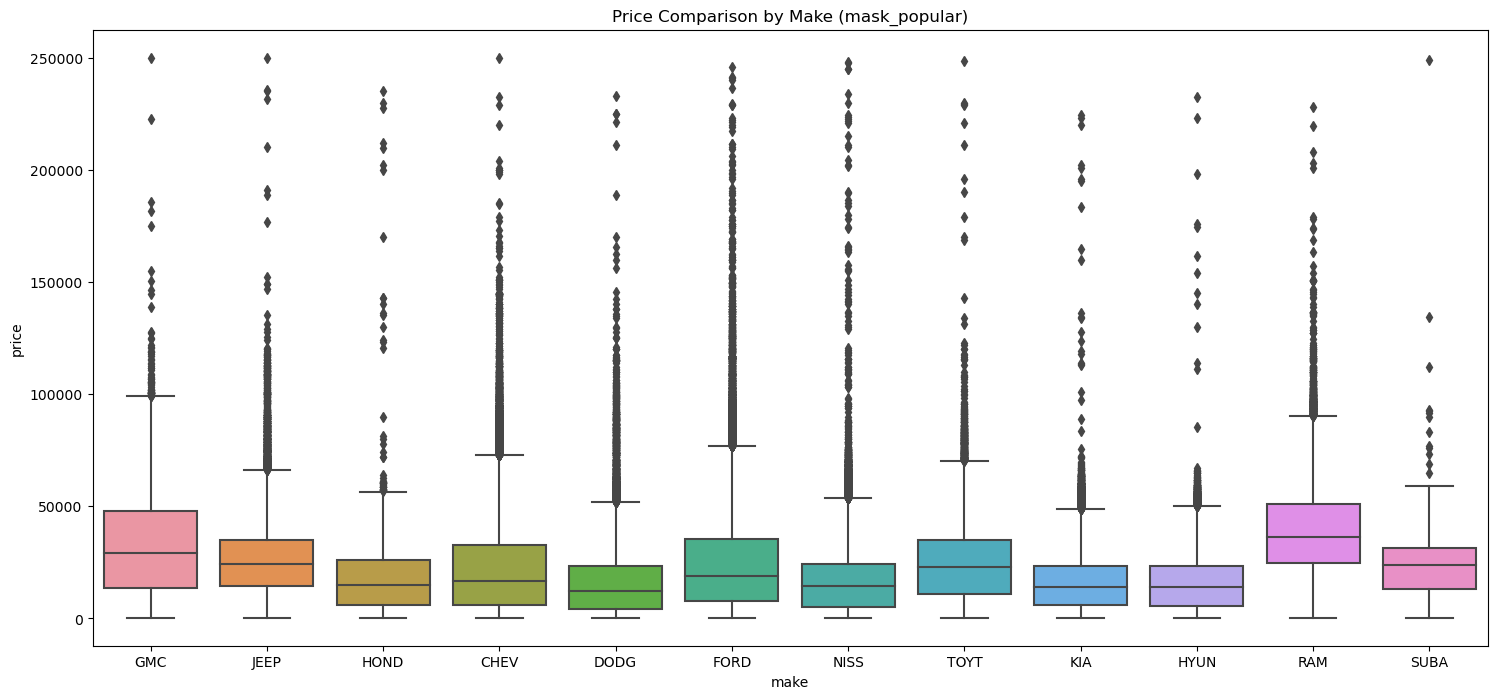

In [11]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_popular])
plt.title("Price Comparison by Make (mask_popular)")
plt.show()

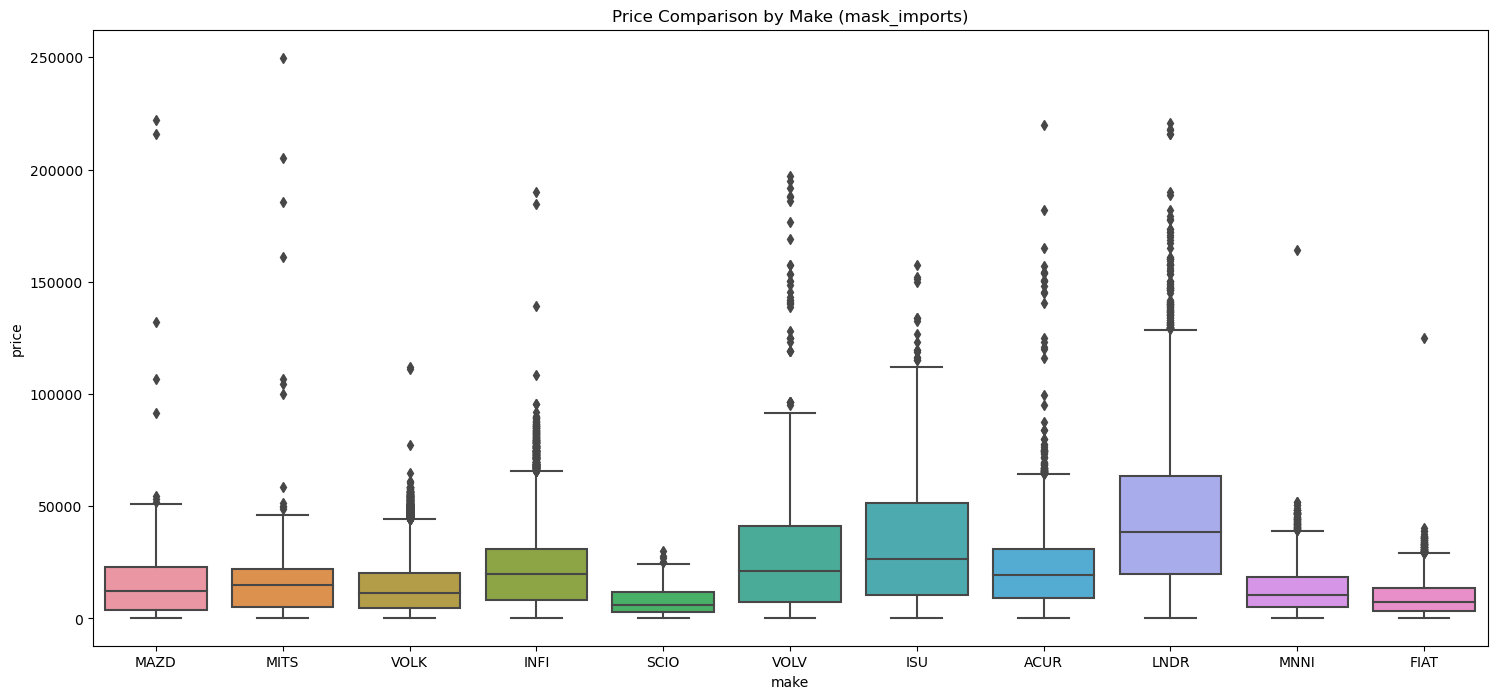

In [12]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_imports])
plt.title("Price Comparison by Make (mask_imports)")
plt.show()

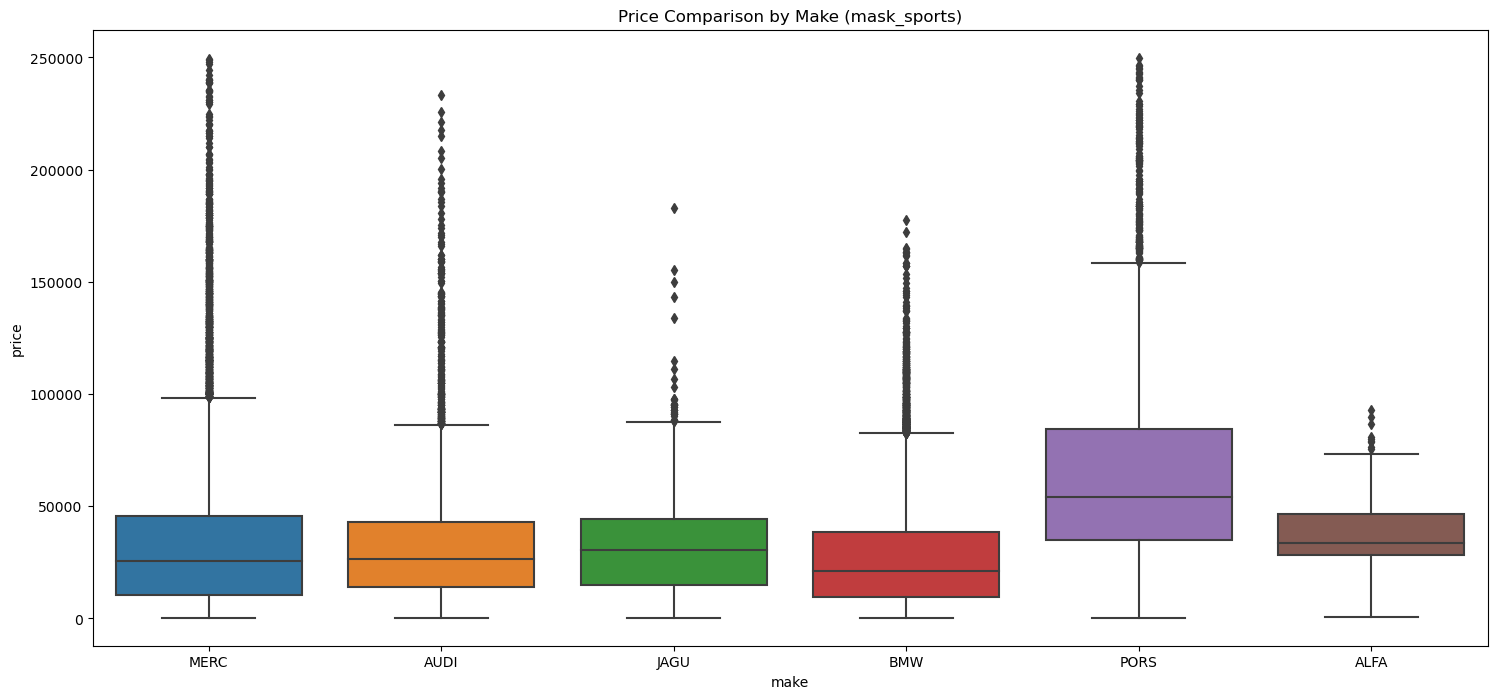

In [13]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_sports])
plt.title("Price Comparison by Make (mask_sports)")
plt.show()

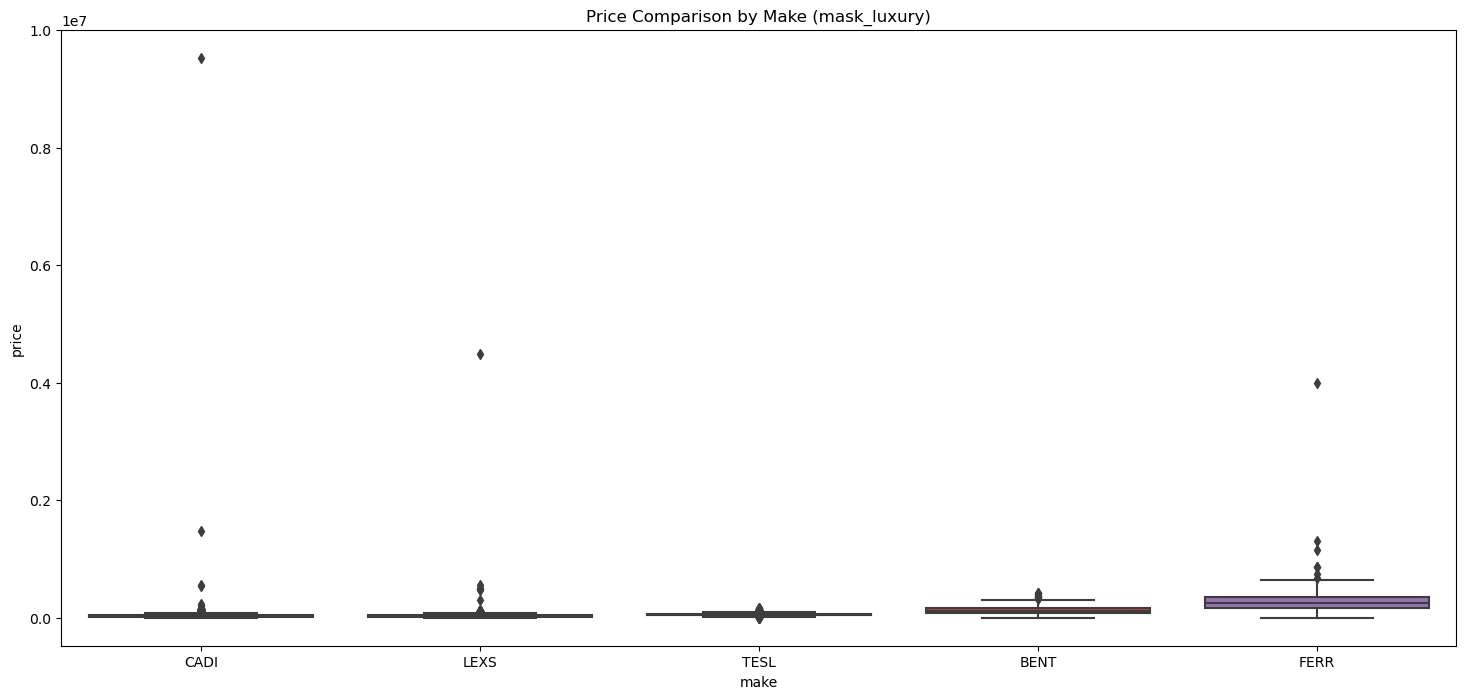

In [14]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_luxury])
plt.title("Price Comparison by Make (mask_luxury)")
plt.show()

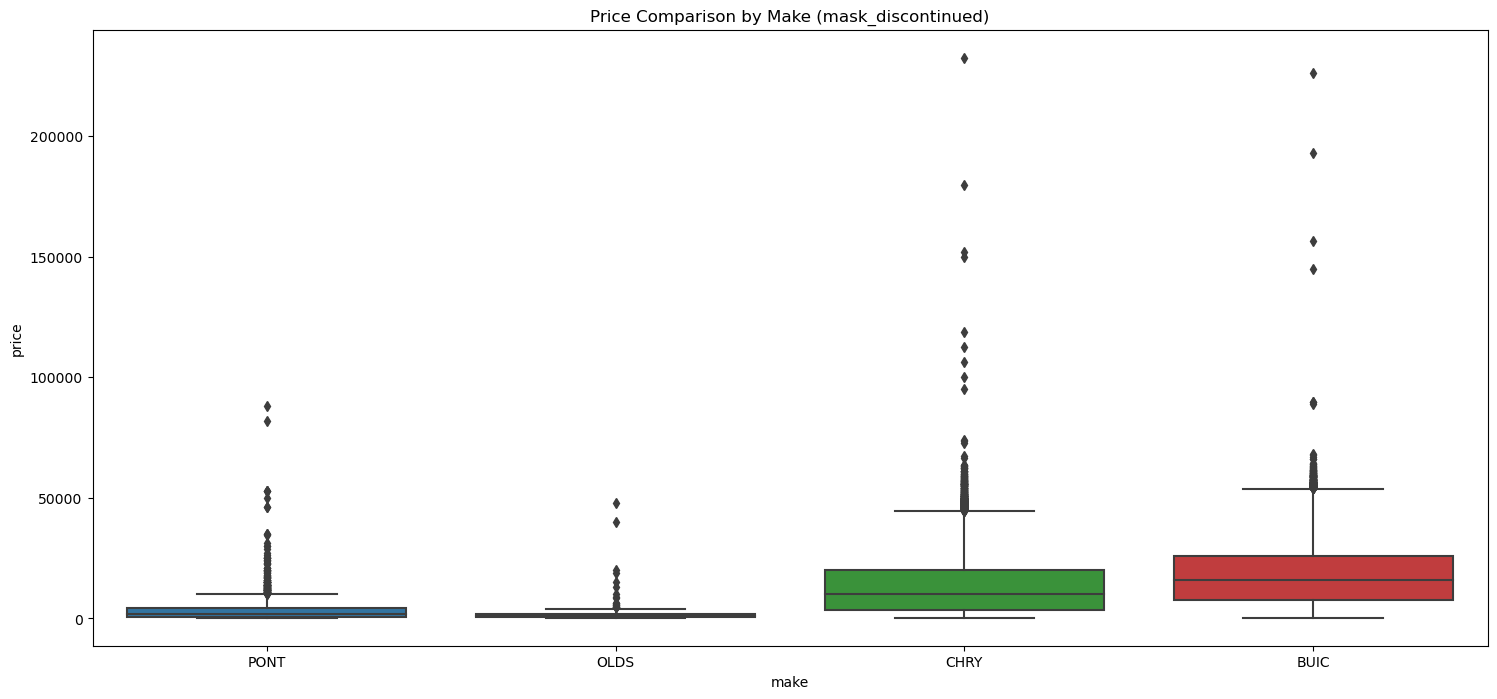

In [15]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_discontinued])
plt.title("Price Comparison by Make (mask_discontinued)")
plt.show()

Number of results: 16056


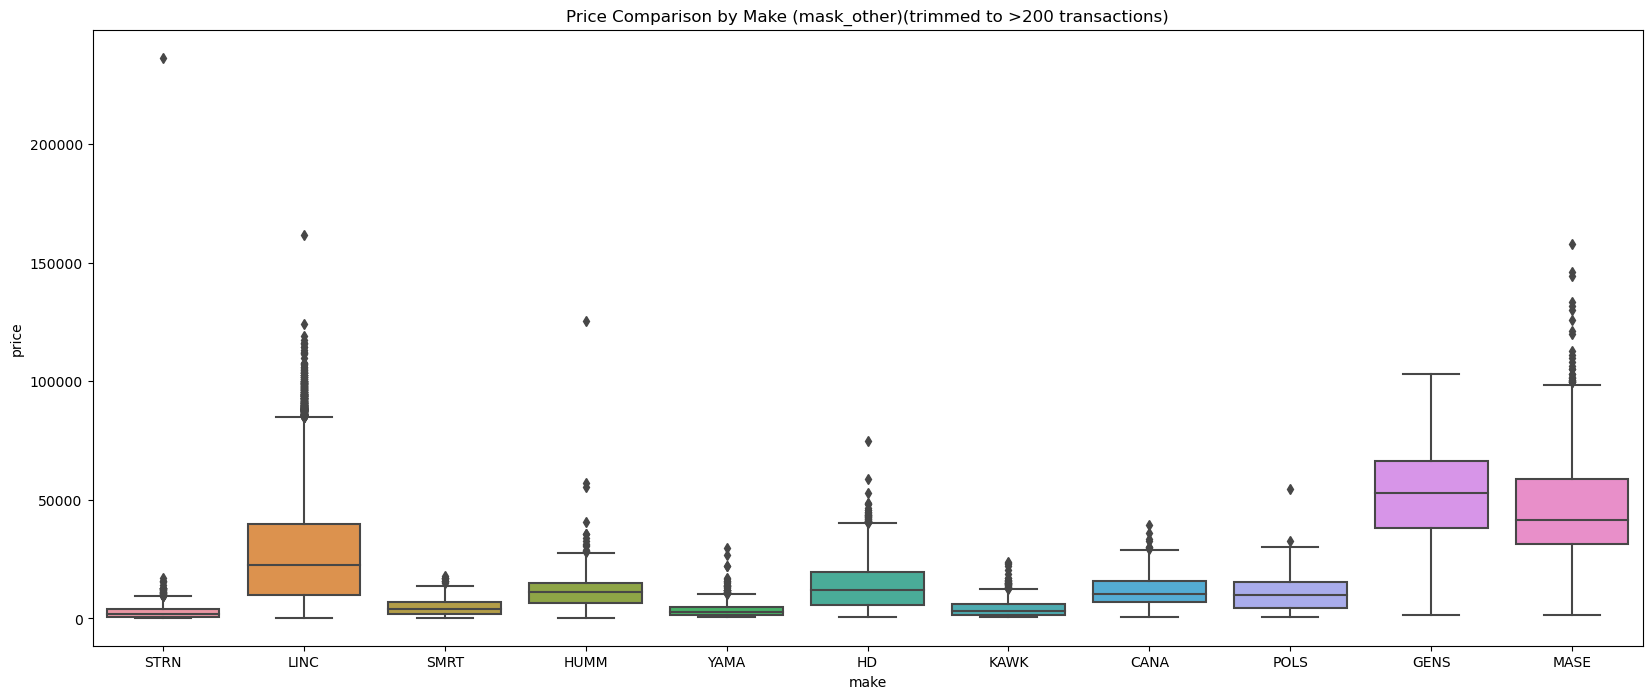

In [16]:
#trimming this down to significant data points (more than 200 transactions)
make_counts = tn_auto_reg_f['make'].value_counts()
mask_make_counts = tn_auto_reg_f['make'].isin(make_counts[make_counts > 200].index)

#boxplot like all the other masks above
plt.figure(figsize=(20,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_other & mask_make_counts])
print("Number of results: " + str(len(tn_auto_reg_f[mask_other & mask_make_counts])))
plt.title("Price Comparison by Make (mask_other)(trimmed to >200 transactions)")
plt.show()

In [17]:
print("Showing the other mask, noting that less than 200 transactions were excluded from the above boxplot")
tn_auto_reg_f[mask_other]['make'].value_counts()

Showing the other mask, noting that less than 200 transactions were excluded from the above boxplot


LINC    8457
HD      2043
STRN    1010
GENS     995
MASE     639
KAWK     582
SMRT     566
POLS     514
YAMA     481
HUMM     406
CANA     363
Name: make, dtype: int64

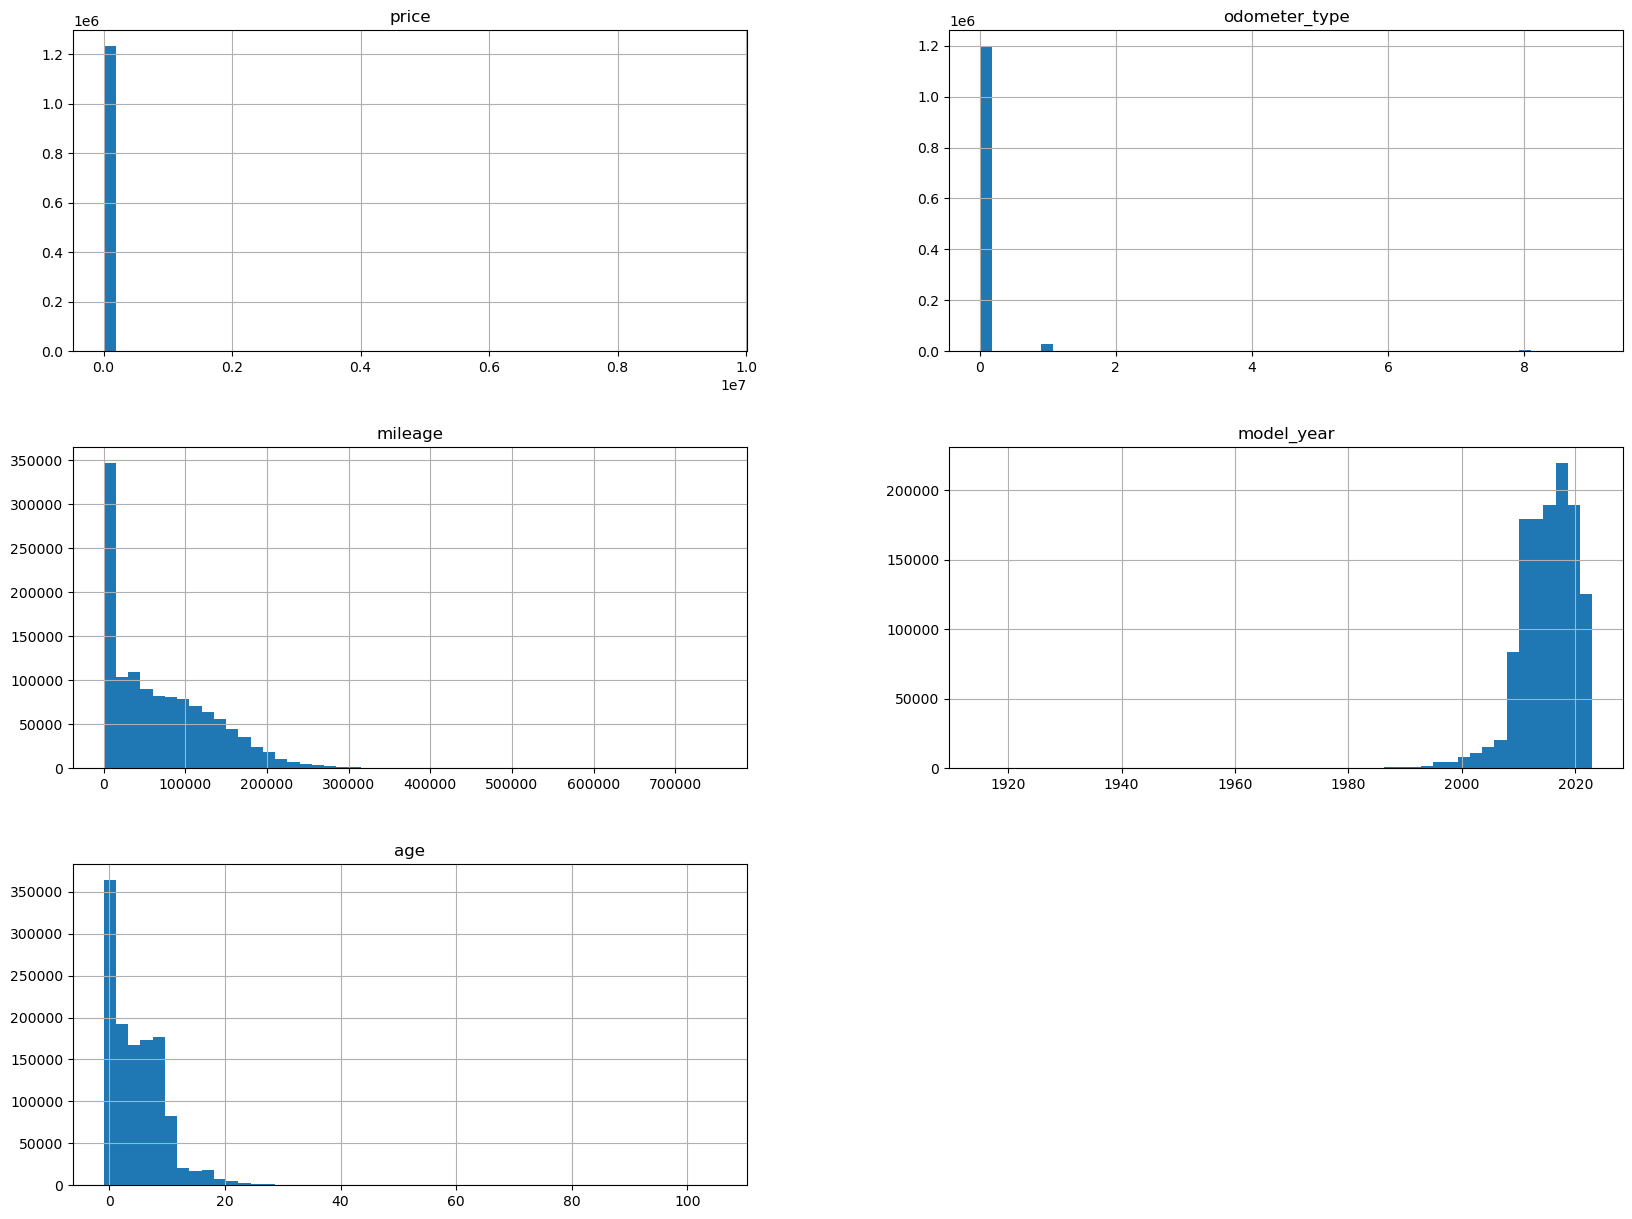

Price, mileage, and age are confirmed by corr analysis to be strong indicators.
Striving for a normal distribution will take some work


In [18]:
tn_auto_reg_f[["price","odometer_type","mileage","model_year","age"]].hist(bins=50, figsize=(20,15))
plt.show()
print("Price, mileage, and age are confirmed by corr analysis to be strong indicators.")
print("Striving for a normal distribution will take some work")

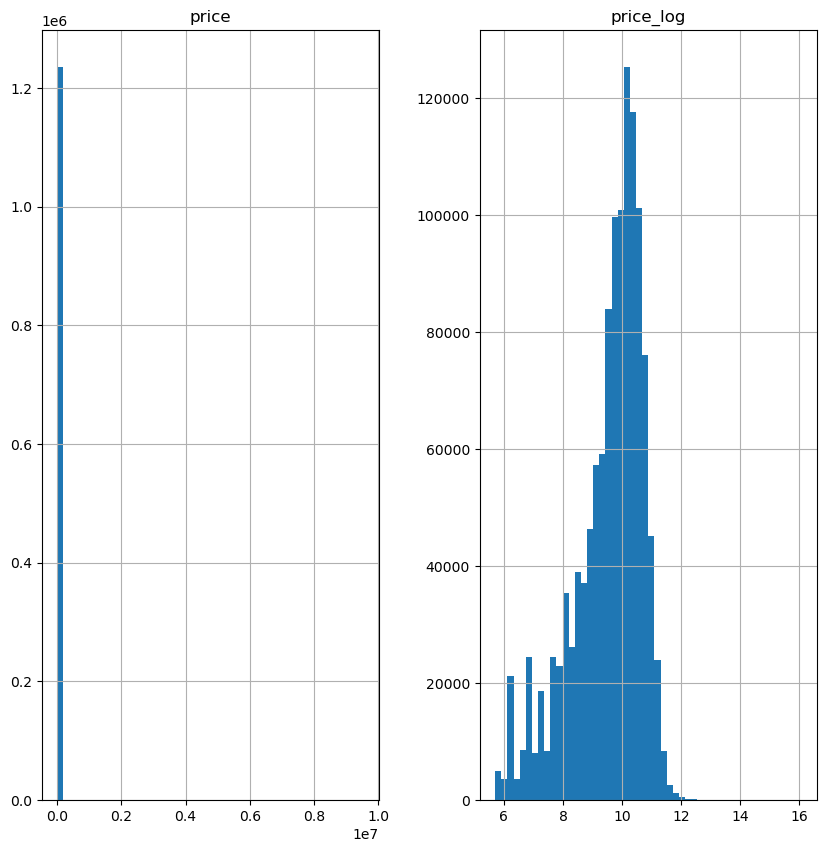

In [19]:
tn_auto_reg_f['price_log'] = np.log1p(tn_auto_reg_f['price'])

tn_auto_reg_f[["price","price_log"]].hist(bins=50, figsize=(10,10))
plt.show()

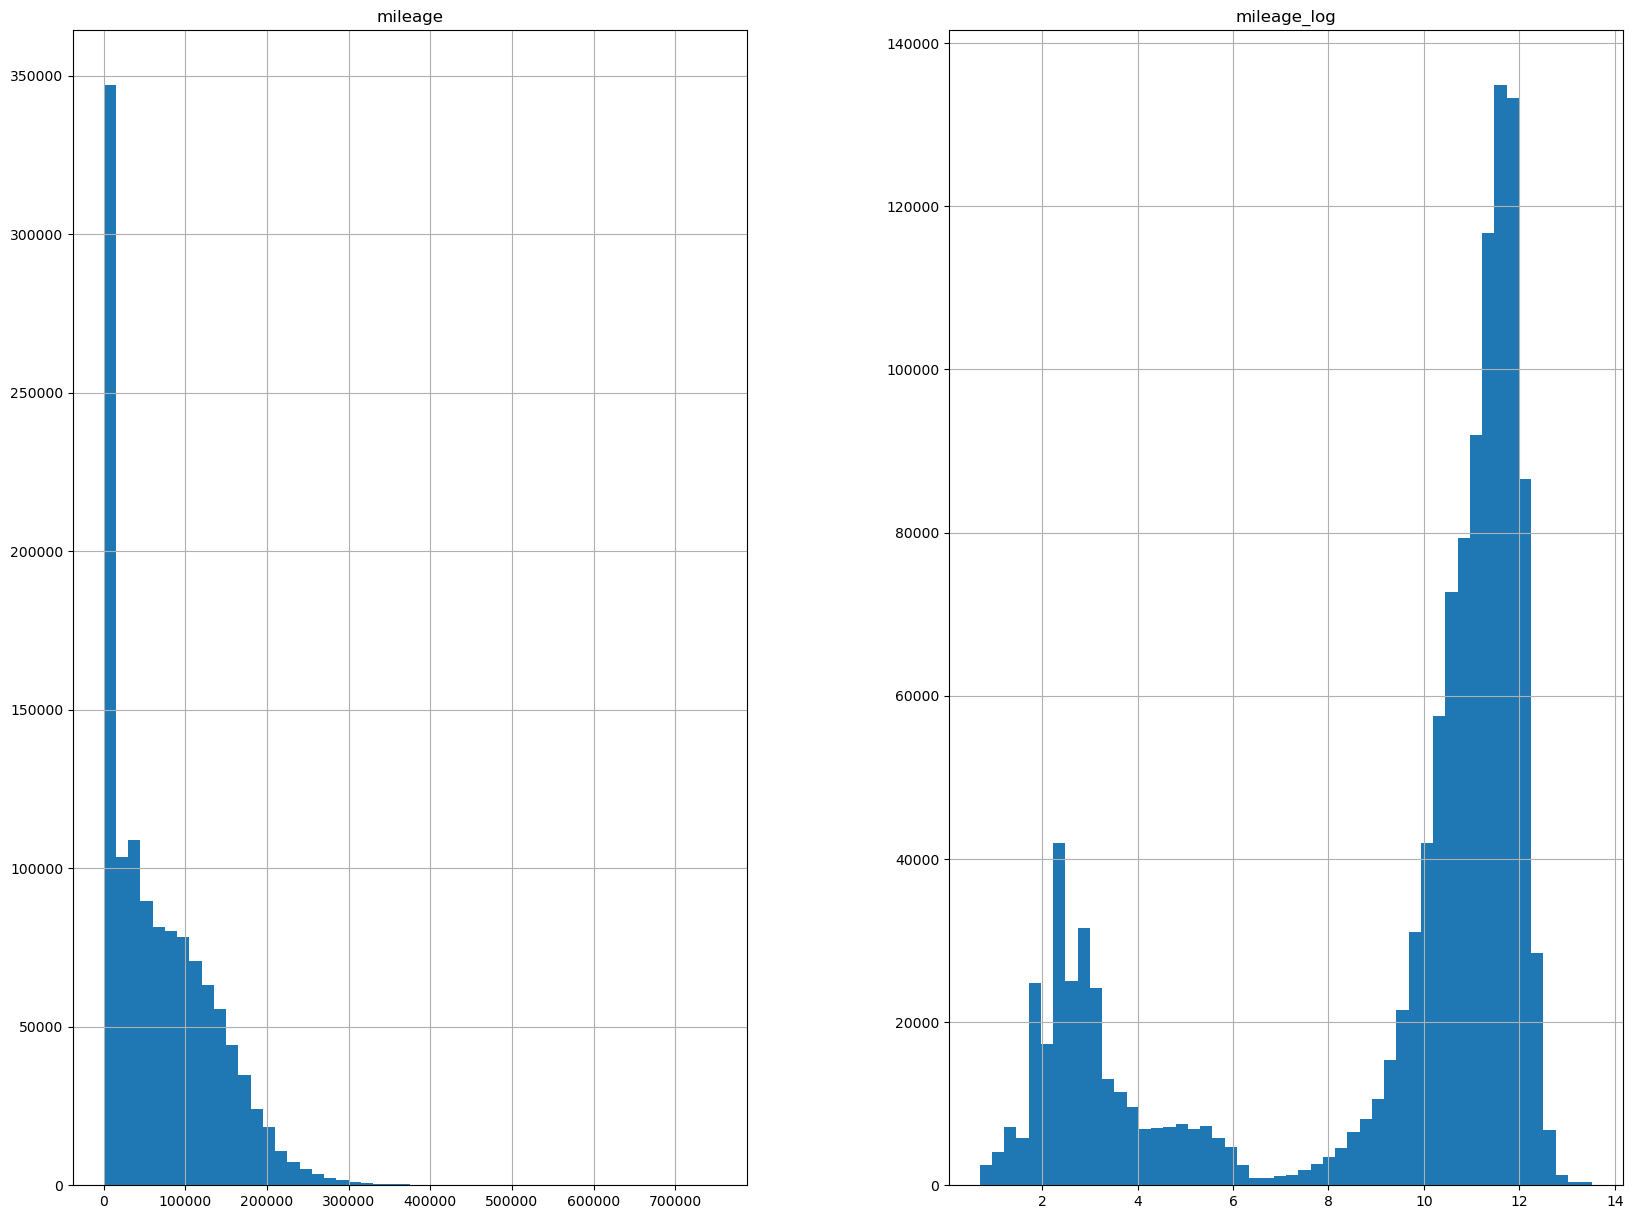

In [20]:
tn_auto_reg_f['mileage_log'] = np.log1p(tn_auto_reg_f['mileage'])

tn_auto_reg_f[["mileage","mileage_log"]].hist(bins=50, figsize=(20,15))
plt.show()

Log(age) didn't compute and model year didn't look any different.  Left them alone

Showing transformations on right side that will be prefered in ML algorithm


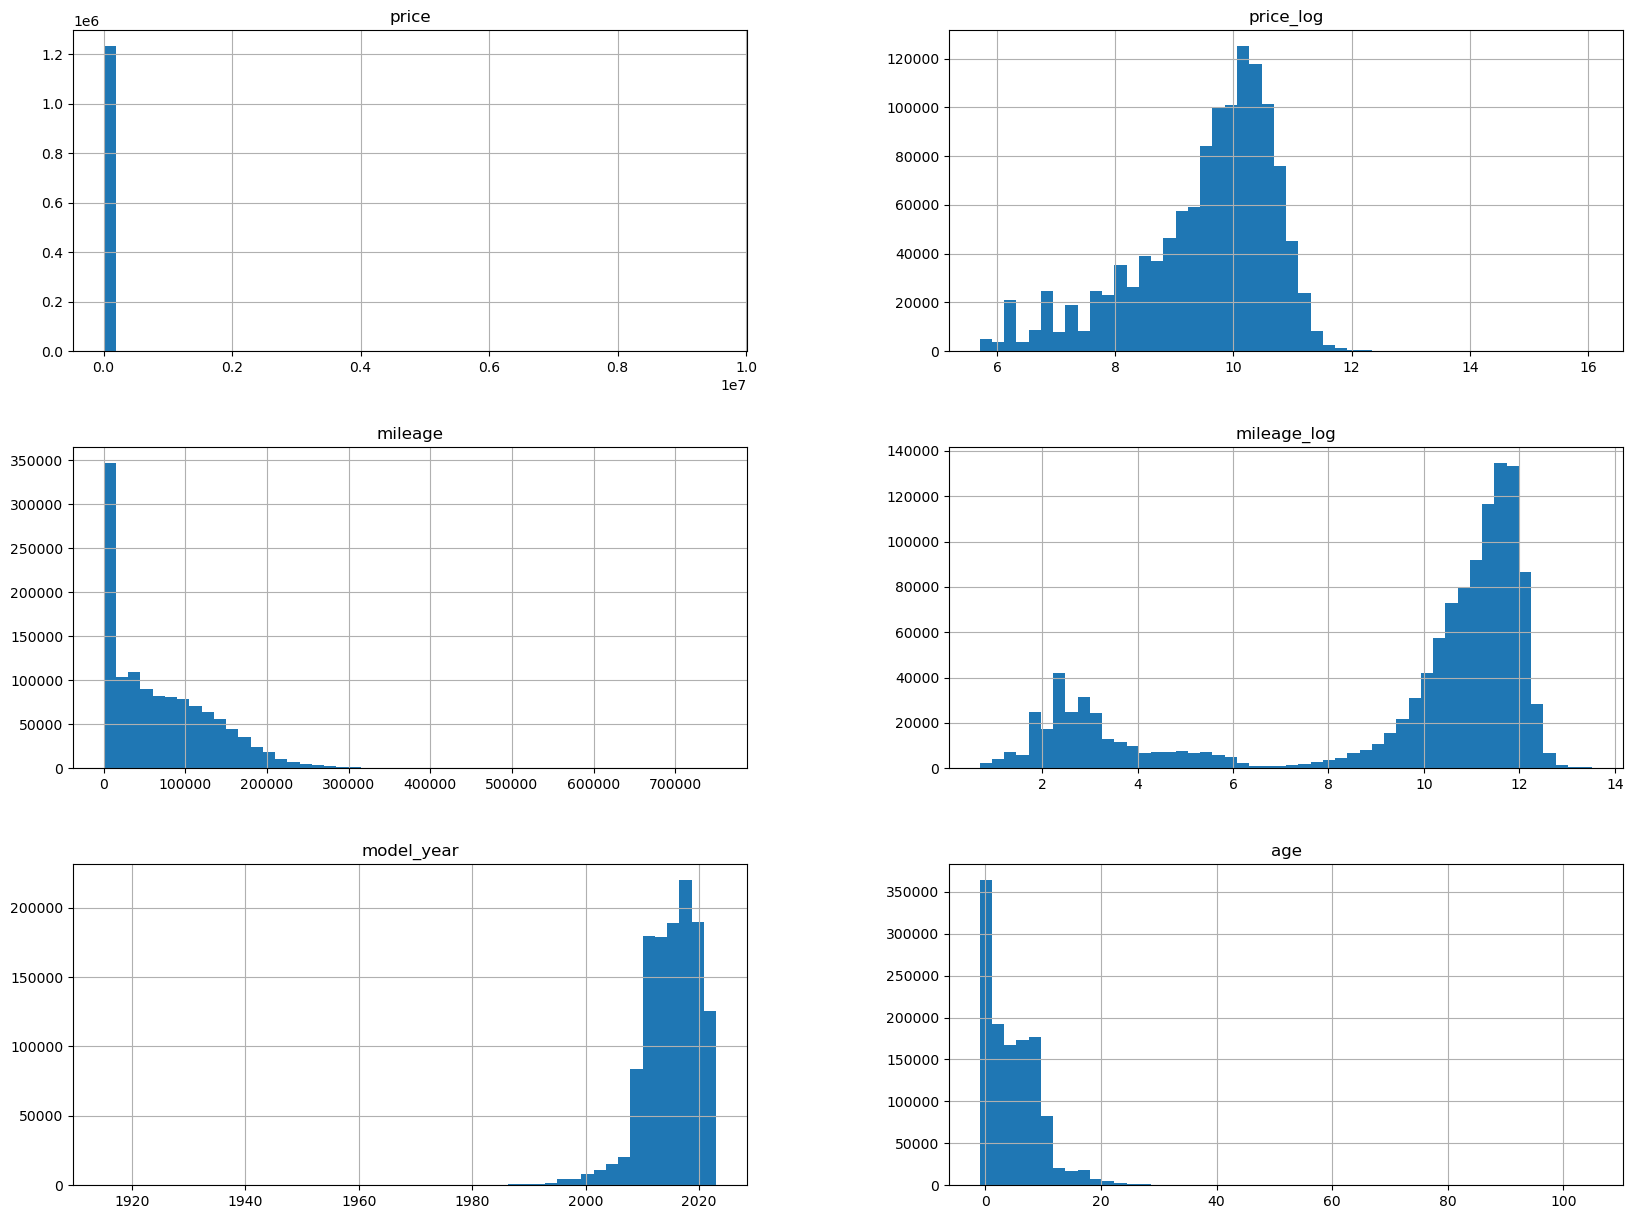

In [21]:
print("Showing transformations on right side that will be prefered in ML algorithm")
tn_auto_reg_f[["price","price_log","mileage","mileage_log","model_year","age"]].hist(bins=50, figsize=(20,15))
plt.show()

In [22]:
# determine an average price for each make/model for both new and used vehicles
avg_price = tn_auto_reg_f.groupby(['make', 'model', 'new_used_N'])['price'].mean().reset_index()
avg_price = avg_price.pivot_table(index=['make', 'model'], columns='new_used_N', values='price', aggfunc='first').reset_index()
avg_price.columns.name = None
avg_price = avg_price[['make', 'model', 1, 0]]

# filter to only rows with non-null values in both 'new' and 'used' columns
avg_price_filtered = avg_price[avg_price[[1, 0]].notnull().all(axis=1)]

# change column names 
avg_price_filtered = avg_price_filtered.rename(columns={'1': 'new_avg', '0': 'used_avg'})

print("Average prices shown below: 1 is New, 0 is Used")
print(avg_price_filtered.sample(20).round(0))

print("Seeing some models go up on average.")

Average prices shown below: 1 is New, 0 is Used
      make model         1        0
4601  JEEP   SPT   58810.0   7274.0
5353  MAZD   JM1   27677.0   7959.0
3601    HD   XL1   10754.0   4645.0
7924  YAMA    MT    7898.0   3600.0
6832   RAM    ST   29816.0   5000.0
3847  HOND   PIO   18512.0   9923.0
6412  POLS   A18    5855.0  10998.0
6663   RAM   150   50218.0  29372.0
1222  CHEV   CK3   50138.0  20913.0
4365  JAGU   EPC   54358.0  38952.0
7508  TOYT   WZ1   60415.0  55072.0
7424  TOYT   SUP   55452.0  48907.0
667   BUIC   REG   31941.0  10764.0
6846   RAM   TRX  106599.0  86204.0
5683  MERC   M1C   37983.0  20831.0
7325  TOYT   LAN   78958.0  32198.0
1377  CHEV   GK1   52017.0   1282.0
1896  DODG    CH   22738.0  16950.0
718   CADI   6DB   39860.0  37277.0
5569  MERC   CLA   46958.0  20952.0
Seeing some models go up on average.


C:\Users\bobbs\AppData\Local\Temp\ipykernel_13032\3464386721.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['New', 'Used'])


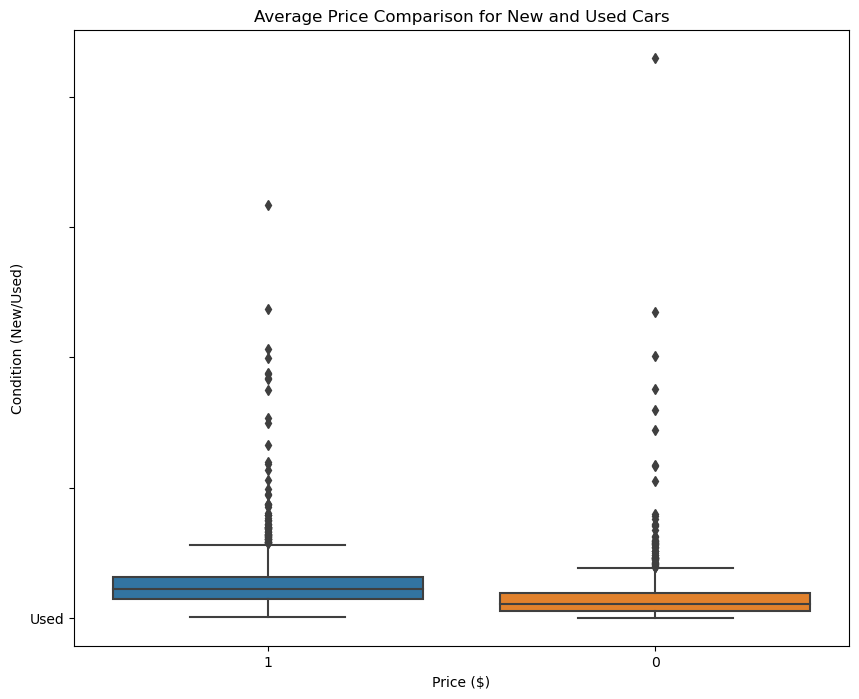

In [23]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10,8))

# Plot boxplots for new and used cars side by side
sns.boxplot(data=avg_price_filtered[[1, 0]],  ax=ax)

# Set title and axis labels
ax.set_title("Average Price Comparison for New and Used Cars")
ax.set_xlabel("Price ($)")
ax.set_ylabel("Condition (New/Used)")
ax.set_yticklabels(['New', 'Used'])

# Show plot
plt.show()

In [24]:

# Sort by VIN
sorted = tn_auto_reg_f.sort_values(by=['vin','age'])

# Count the number of records per VIN 
vin_counts = sorted['vin'].value_counts()

# Exclude any cars with less than 5 records
multiple_vins = vin_counts[vin_counts > 1].index

sorted = sorted[sorted['vin'].isin(multiple_vins)] #refactor here? j
print("Number of VINs with more than 1 records:", len(multiple_vins))

known_new_VINs = tn_auto_reg_f[tn_auto_reg_f['new_used_N']==1]['vin'].unique()
print("Number of new VINs:", len(known_new_VINs))

sorted_and_new = sorted[sorted['vin'].isin(known_new_VINs)]
print("Number of VINs that have new and used registrations:", len(sorted_and_new))

sorted_and_new.describe()

Number of VINs with more than 1 records: 94065
Number of new VINs: 226854
Number of VINs that have new and used registrations: 2915


,price,odometer_type,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK,new_used_N,new_used_U,price_log,mileage_log
count,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.00000,2915.000000,2915.000000,2915.0,2915.0,2915.000000,2915.000000
mean,45596.515482,0.021955,63.486106,2020.116981,-0.046655,0.883362,0.042196,0.021269,0.022642,0.013722,0.01681,0.711492,0.288508,1.0,0.0,10.638925,3.271098
std,20489.313489,0.201738,98.850799,1.521648,0.480096,0.321044,0.201070,0.144305,0.148783,0.116355,0.12858,0.453146,0.453146,0.0,0.0,0.436062,1.298050
min,580.000000,0.000000,1.000000,2015.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.0,0.0,6.364751,0.693147
25%,31629.150000,0.000000,10.000000,2019.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.0,0.0,10.361866,2.397895
50%,42404.000000,0.000000,19.000000,2020.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.0,0.0,10.655022,2.995732
75%,55027.220000,0.000000,66.500000,2021.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.0,0.0,10.915601,4.212100
max,330199.000000,8.000000,500.000000,2023.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0,0.0,12.707454,6.216606


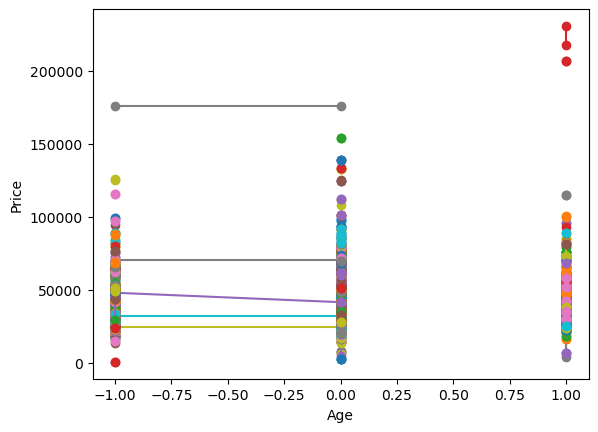

In [25]:
#For the last 2 plots, you can try a 3d graph finding an order for the VINs that makes sense (for example category or make). 
#You can also create a new feature tagging the cars whose price increased and check if there are predictors for that 
#(correlation table). Then, use one of these predictors to order the VINs along the 3rd axis of the plot.

# Plot scatterplot with lines connecting records for each VIN
fig, ax = plt.subplots()

current_vin = None
current_x = None
current_y = None

for index, row in sorted_and_new.iterrows():
    if row['vin'] != current_vin:
        if current_x is not None and current_y is not None:
            ax.plot(current_x, current_y, marker='o' )#label=current_vin, )
        current_vin = row['vin']
        current_x = [row['age']]
        current_y = [row['price']]
    else:
        current_x.append(row['age'])
        current_y.append(row['price'])

# Add legend and axis labels
#ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Price')
plt.show()

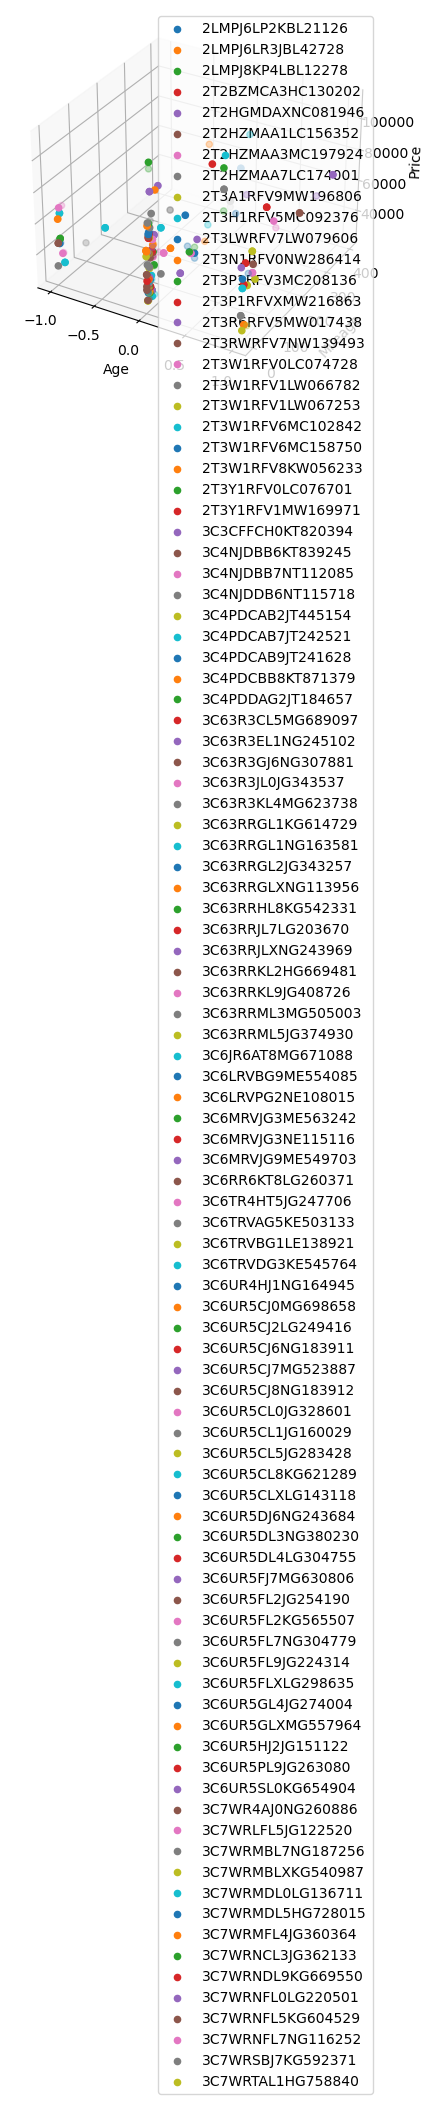

In [26]:
from mpl_toolkits.mplot3d import Axes3D

# Slice the middle 200 entries
start_idx = (len(sorted_and_new) - 200) // 2
end_idx = start_idx + 200
sorted_and_new = sorted_and_new.iloc[start_idx:end_idx]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialize variables for storing data for each VIN
current_vin = None
current_x = None
current_y = None
current_z = None

for index, row in sorted_and_new.iterrows():
    if row['vin'] != current_vin:
        if current_x is not None and current_y is not None and current_z is not None:
            ax.scatter(current_x, current_y, current_z, marker='o', label=current_vin)
        current_vin = row['vin']
        current_x = [row['age']]
        current_y = [row['mileage']]
        current_z = [row['price']]
    else:
        current_x.append(row['age'])
        current_y.append(row['mileage'])
        current_z.append(row['price'])

# Add legend and axis labels
ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Mileage')
ax.set_zlabel('Price')
plt.show()

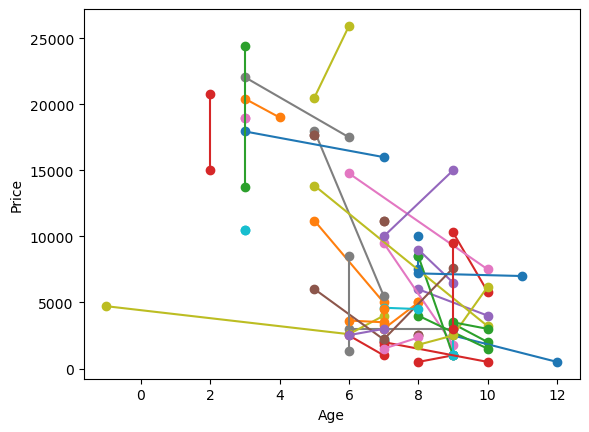

In [27]:
# Plot scatterplot with lines connecting records for each VIN
fig, ax = plt.subplots()

current_vin = None
current_x = None
current_y = None

for index, row in sorted.iloc[100:200].iterrows():
    if row['vin'] != current_vin:
        if current_x is not None and current_y is not None:
            ax.plot(current_x, current_y, marker='o' )#label=current_vin, )
        current_vin = row['vin']
        current_x = [row['age']]
        current_y = [row['price']]
    else:
        current_x.append(row['age'])
        current_y.append(row['price'])

# Add legend and axis labels
#ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Price')
plt.show()

Most vehicles decrease in value after converting to new, but a few increase in value. Believe it makes sense that a dealership may value a trade-in at a lower price than when it is resold on their lot. 

Below begins the 3rd stage gate 


In [28]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Analysis completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Analysis completed (total time): 46.0
This section took: 38.0
(in seconds)


Below is the code for the final stagegate of this term project. 

In [29]:
tn_auto_reg_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236247 entries, 0 to 1236246
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   vin                    1236247 non-null  object 
 1   price                  1236247 non-null  float64
 2   odometer_type          1236247 non-null  int64  
 3   mileage                1236247 non-null  int64  
 4   county                 1236247 non-null  object 
 5   zip                    1236247 non-null  object 
 6   model_year             1236247 non-null  int64  
 7   make                   1236247 non-null  object 
 8   model                  1236247 non-null  object 
 9   vehicle_type           1236247 non-null  object 
 10  new_used               1236247 non-null  object 
 11  title_issue_date       1236247 non-null  object 
 12  purchase_date          1236247 non-null  object 
 13  age                    1236247 non-null  int64  
 14  make_cat_popular  

In [30]:
print("Dropping all non-feature columns\n")
dropped = tn_auto_reg_f.drop("vin", axis=1)
dropped = dropped.drop("odometer_type", axis=1)
dropped = dropped.drop("county", axis=1)
dropped = dropped.drop("zip", axis=1)
dropped = dropped.drop("model_year", axis=1)
dropped = dropped.drop("make", axis=1)
dropped = dropped.drop("model", axis=1)
dropped = dropped.drop("vehicle_type", axis=1)
dropped = dropped.drop("new_used", axis=1)
dropped = dropped.drop("title_issue_date", axis=1)
dropped = dropped.drop("purchase_date", axis=1)
dropped = dropped.drop("mileage", axis=1)
dropped = dropped.drop("price", axis=1)

dropped.info()

Dropping all non-feature columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236247 entries, 0 to 1236246
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   age                    1236247 non-null  int64  
 1   make_cat_popular       1236247 non-null  int64  
 2   make_cat_imports       1236247 non-null  int64  
 3   make_cat_sports        1236247 non-null  int64  
 4   make_cat_luxury        1236247 non-null  int64  
 5   make_cat_discontinued  1236247 non-null  int64  
 6   make_cat_other         1236247 non-null  int64  
 7   type_AUTO              1236247 non-null  int64  
 8   type_TRUCK             1236247 non-null  int64  
 9   new_used_N             1236247 non-null  int64  
 10  new_used_U             1236247 non-null  int64  
 11  price_log              1236247 non-null  float64
 12  mileage_log            1236247 non-null  float64
dtypes: float64(2), int64(11)
memory usage:

In [31]:
def price_cat_proportions(data):
    #print ("Data_price_log.value_counts() = \n" + str(data["price_log"].value_counts() ) +" and len = " + str( (len(data) + 1e-10 )))
    return data["price_log"].value_counts() / (len(data) + 1e-10)

train_set, test_set = train_test_split(dropped, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": price_cat_proportions(tn_auto_reg_f),
    #"Stratified": price_cat_proportions(strat_test_set_disc),
    "Random": price_cat_proportions(test_set),
}).sort_index()#.fillna(0) #<- Debugging Flag - Not sure about .fillna(0) here.  Should figure out why NaNs popped up. 
compare_props["Rand. %error"] = ( 100 * compare_props["Random"] ) / (compare_props["Overall"] - 100 )    #<- are these supposed
#compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100 #<- to be different? Was 1

#Look for divide by zero errors here => NaN 

## the stratified better reflects the original distribution?
compare_props.sample(15).round(-1)

,Overall,Random,Rand. %error
10.274734,0.0,0.0,-0.0
10.735607,0.0,NaN,NaN
9.721782,0.0,NaN,NaN
9.423272,0.0,0.0,-0.0
9.718526,0.0,0.0,-0.0
10.464044,0.0,NaN,NaN
9.241376,0.0,NaN,NaN
10.468375,0.0,0.0,-0.0
10.711908,0.0,0.0,-0.0
9.887155,0.0,0.0,-0.0


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

In [33]:
from sklearn.preprocessing import OrdinalEncoder

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder()),
])

In [34]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

In [35]:
#Copy the target into the labels set
registrations_labels = train_set['price_log'].copy()

#Copy the dropped data into the registrations df 
registrations = train_set.drop('price_log',axis=1).copy()

print(registrations.info() )
print("\n")
print(registrations_labels.info() )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988997 entries, 351663 to 121958
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   age                    988997 non-null  int64  
 1   make_cat_popular       988997 non-null  int64  
 2   make_cat_imports       988997 non-null  int64  
 3   make_cat_sports        988997 non-null  int64  
 4   make_cat_luxury        988997 non-null  int64  
 5   make_cat_discontinued  988997 non-null  int64  
 6   make_cat_other         988997 non-null  int64  
 7   type_AUTO              988997 non-null  int64  
 8   type_TRUCK             988997 non-null  int64  
 9   new_used_N             988997 non-null  int64  
 10  new_used_U             988997 non-null  int64  
 11  mileage_log            988997 non-null  float64
dtypes: float64(1), int64(11)
memory usage: 98.1 MB
None


<class 'pandas.core.series.Series'>
Int64Index: 988997 entries, 351663 to 121958
Se

In [36]:
from sklearn.compose import ColumnTransformer

num_attribs = ["mileage_log","age"] 
cat_attribs = ["new_used_N","new_used_U","make_cat_popular","make_cat_imports","make_cat_sports","make_cat_luxury",
               "make_cat_discontinued","make_cat_other", "type_AUTO", "type_TRUCK"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

registrations_prepared = full_pipeline.fit_transform(registrations)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [37]:
registrations_prepared

array([[ 0.79577977,  1.42097952,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-2.08505578, -1.00706151,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.63121432,  0.20695901,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.76659396,  0.40929576,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.32696057, -0.1977145 ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.71345529,  1.01630601,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

In [38]:
registrations_prepared.shape

(988997, 12)

In [39]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Pipline created (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Pipline created (total time): 55.0
This section took: 9.0
(in seconds)


In [40]:
import statsmodels.api as sm
X_const = sm.add_constant(registrations_prepared)
OLS_model = sm.OLS(registrations_labels,X_const) 
result = OLS_model.fit()
result.summary() #Erroring here

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                 1.220e+05
Date:                Sat, 29 Apr 2023   Prob (F-statistic):               0.00
Time:                        14:40:14   Log-Likelihood:            -1.1846e+06
No. Observations:              988997   AIC:                         2.369e+06
Df Residuals:                  988986   BIC:                         2.369e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.42e+09    8.5e+10      0.028      0.977   -1.64e+11    1.69e+11
x1            -0.2994      0.002   -167.537      0.000      -0.303      -0.296
x2            -0.7029      0.001   -670.089      0.000      -0.705      -0.701
x3          1.209e+09    4.3e+10      0.028      0.978   -8.31e+10    8.55e+10
x4          1.209e+09    4.3e+10      0.028      0.978   -8.31e+10    8.55e+10
x5          1.015e+09   1.37e+11      0.007      0.994   -2.68e+11     2.7e+11
x6          1.015e+09   1.37e+11      0.007      0.994   -2.68e+11     2.7e+11
x7          1.015e+09   1.37e+11      0.007      0.994   -2.68e+11     2.7e+11
x8          1.015e+09   1.37e+11      0.007      0.994   -2.68e+11     2.7e+11
x9          1.015e+09   1.37e+11      0.007      0.994   -2.68e+11     2.7e+11
x10         1.015e+09   1.37e+11      0.007      0.994   -2.68e+11     2.7e+11
x11        -4.645e+09   1.14e+10     -0.409      0.682   -2.69e+10    1.76e+10
x12        -4.645e+09   1.14e+10     -0.409      0.682   -2.69e+10    1.76e+10
==============================================================================
Omnibus:                   149981.049   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1454556.501
Skew:                          -0.429   Prob(JB):                         0.00
Kurtosis:                       8.879   Cond. No.                     7.27e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.89e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [41]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(registrations_prepared, registrations_labels)
 

LinearRegression()

In [42]:
print(registrations_prepared.shape)
print(registrations_labels.shape)

(988997, 12)
(988997,)


In [43]:
# let's try the full preprocessing pipeline on a few training instances

some_data = registrations_prepared[:5]
some_labels = registrations_labels[:5]

cols = num_attribs + cat_attribs

some_data_df = pd.DataFrame(some_data, columns=cols)

some_data_prepared = full_pipeline.transform(some_data_df)



C:\Users\bobbs\AppData\Local\Temp\ipykernel_13032\4143674071.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  some_labels = registrations_labels[:5]


In [44]:
#Compare prediction against the actual values
print("Predictions:", list(np.round(lin_reg.predict(some_data_prepared),1)))
print("Labels     :", list(some_labels))

Predictions: [11.2, 11.0, 10.8, 10.7, 10.9]
Labels     : [9.105090961257085, 10.366560973264606, 9.678024438114226, 6.90875477931522, 11.048162797858131]


In [45]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('First Predictions Completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

First Predictions Completed (total time): 60.0
This section took: 5.0
(in seconds)


In [46]:
from sklearn.metrics import mean_squared_error

vehicle_price_predictions = lin_reg.predict(registrations_prepared)
lin_mse = mean_squared_error(registrations_labels, vehicle_price_predictions)
lin_rmse = np.sqrt(lin_mse)

print("Mean Squared Error:", round(lin_rmse,-2))

Mean Squared Error: 0.0


In [47]:
from sklearn.metrics import mean_absolute_error

registrations_predictions = lin_reg.predict(registrations_prepared)
lin_mae = mean_absolute_error(registrations_labels, registrations_predictions)
print("Mean Absolute Error:", round(lin_mae,1))

Mean Absolute Error: 0.6


In [48]:
# from sklearn.metrics import mean_absolute_percentage_error# mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Absolute Percentage Error:")
round(mean_absolute_percentage_error(registrations_labels, registrations_predictions),1)

Absolute Percentage Error:


6.7

In [49]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Errors computed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Errors computed (total time): 60.0
This section took: 0.0
(in seconds)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

round(mean_absolute_percentage_error(housing_labels, housing_predictions),1)
28.5
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
print("Mean Absolute Error:", round(lin_mae,1))
Mean Absolute Error: 49438.7
Okay, this is better than nothing but clearly not a great score: most districts’ median_housing_values range between $120,000 and \$265,000, so a typical prediction error of $67,874 is not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough.
The main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. This model is not regularized, so this rules out the last option. You could try to add more features (e.g., the log of the population), but first let’s try a more complex model to see how it does.

The Mean absolute error represents the average of the absolute difference between the actual and predicted values in the dataset. It measures the average of the residuals in the dataset.
image.png image-2.png

Mean Squared Error represents the average of the squared difference between the original and predicted values in the data set. It measures the variance of the residuals. image-3.png

Root Mean Squared Error is the square root of Mean Squared error. It measures the standard deviation of residuals. image-4.png

RMSE is widely used than MSE to evaluate the performance of the regression model with other random models as it has the same units as the dependent variable (Y-axis).

# from sklearn.metrics import mean_absolute_percentage_error# mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

round(mean_absolute_percentage_error(housing_labels, housing_predictions),1)
28.5



5.2 Decision Tree




In [50]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(registrations_prepared, registrations_labels)

DecisionTreeRegressor(random_state=42)

In [51]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Tree fit completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Tree fit completed (total time): 74.0
This section took: 14.0
(in seconds)


In [52]:
housing_predictions = tree_reg.predict(registrations_prepared)
tree_mse = mean_squared_error(registrations_labels, registrations_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.7969706014036111

In [53]:
mean_absolute_percentage_error(registrations_labels, registrations_predictions)

6.65063879438957

#Slow below here#

In [54]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(registrations_prepared, registrations_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

In [55]:
registrations_predictions = forest_reg.predict(registrations_prepared)
forest_mse = mean_squared_error(registrations_labels, registrations_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.4565609265080254

In [56]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Forest fit completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Forest fit completed (total time): 185.0
This section took: 111.0
(in seconds)


In [57]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, registrations_prepared, registrations_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [58]:
def display_scores(scores):
#     print("Scores:", scores)
    print("Mean of 10 'mean_squared_error's:", round(scores.mean(),0))
#     print("Standard deviation:", round(scores.std(),0))

print("Decision Tree")
display_scores(tree_rmse_scores)

Decision Tree
Mean of 10 'mean_squared_error's: 1.0


In [59]:
from sklearn.model_selection import cross_val_score #also very slow 

forest_scores = cross_val_score(forest_reg, registrations_prepared, registrations_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("Random Forest Regression")
display_scores(forest_rmse_scores)

Random Forest Regression
Mean of 10 'mean_squared_error's: 1.0


In [60]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Cross Val Score Completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Cross Val Score Completed (total time): 1211.0
This section took: 1026.0
(in seconds)


In [61]:
lin_scores = cross_val_score(lin_reg, registrations_prepared, registrations_labels,
                                scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

print("Linear Regression")
display_scores(lin_rmse_scores)

Linear Regression
Mean of 10 'mean_squared_error's: 1.0


In [62]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Regression comparisons completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Regression comparisons completed (total time): 1221.0
This section took: 10.0
(in seconds)
